In [2]:
# %%
# Notebook-friendly imports & configuration

from tqdm.notebook import tqdm
import time, os, random, sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

# -------------------- User-editable config --------------------
DATA_DIR = "./data"
CKPT_DIR = "./ckpt"
LOG_DIR = "./runs/exp1"
BATCH_SIZE = 128
EPOCHS = 30
LR = 0.1
NUM_WORKERS = None
SEED = 42
USE_PRETRAINED = False  # whether to load ImageNet weights for the ResNet backbone
RESUME_FROM = None  # set to a path to resume, e.g. './ckpt/best.pth'
# ---------------------------------------------------------------

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Choose num_workers conservatively for notebooks
if NUM_WORKERS is None:
    if os.name == 'nt':
        num_workers = 0  # safe for Windows/Jupyter
    else:
        # limit to a small number so notebook remains responsive
        num_workers = min(4, (os.cpu_count() or 2) - 1)
else:
    num_workers = NUM_WORKERS

print(f"Using num_workers={num_workers}")

# create dirs
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)
Path(LOG_DIR).mkdir(parents=True, exist_ok=True)

Device: cuda
Using num_workers=0


In [3]:
# %%
# Data transforms and dataloders

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std)
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

print("Downloading / preparing CIFAR-10 (may take a minute)...")

train_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_tf)
val_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_tf)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train size: {len(train_ds)}  Val size: {len(val_ds)}")

Files already downloaded and verified
Files already downloaded and verified
Train size: 50000  Val size: 10000


In [5]:
# %%
# Model, loss, optimizer, scheduler

def make_model(num_classes=10, pretrained=USE_PRETRAINED):
    model = models.resnet18(pretrained=pretrained)

    # adapt first conv for 32x32 images and remove maxpool
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = make_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [4]:
# %%
# Training and evaluation functions (notebook-friendly)

def train_epoch(model, loader, criterion, optimizer, device, epoch, log_every=200):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"Train E{epoch}")

    for i, (images, targets) in enumerate(pbar):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

        if (i+1) % log_every == 0:
            pbar.set_postfix(train_loss=running_loss/total, train_acc=correct/total)

    avg_loss = running_loss / total
    acc = correct / total
        
    return avg_loss, acc


def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Val"):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    
    return avg_loss, acc

Sample batch shapes: torch.Size([128, 3, 32, 32]) torch.Size([128])


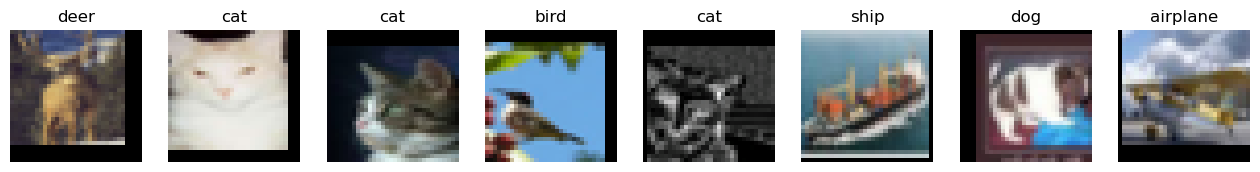

In [5]:
# %%
# Utilities: checkpointing, visualizations

def save_checkpoint(state, path):
    torch.save(state, path)


def load_checkpoint(path, model, optimizer=None, scheduler=None, map_location=None):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt.get('model_state', ckpt))
    if optimizer and 'optimizer_state' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state'])
    if scheduler and 'scheduler_state' in ckpt:
        scheduler.load_state_dict(ckpt['scheduler_state'])
    return ckpt


# small helper to show a batch of (unnormalized) images with labels
def imshow_batch(images, labels, classes, mean=mean, std=std, max_images=8):
    # images: tensor [B,C,H,W]
    images = images.cpu().numpy()
    B = min(images.shape[0], max_images)
    fig, axes = plt.subplots(1, B, figsize=(2*B,2))
    if B == 1:
        axes = [axes]
    for i in range(B):
        img = images[i].transpose(1,2,0)
        img = (img * np.array(std)) + np.array(mean)
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# class names for CIFAR-10
classes = train_ds.classes if hasattr(train_ds, 'classes') else [str(i) for i in range(10)]

# show a quick sample batch
batch = next(iter(train_loader))
imgs, labs = batch
print("Sample batch shapes:", imgs.shape, labs.shape)
imshow_batch(imgs, labs.squeeze(), classes)

In [7]:
# %%
# Training loop (notebook-friendly, saves checkpoints)

best_val_acc = 0.0
start_epoch = 1

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        t0 = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch, log_every=200)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
        scheduler.step()

        elapsed = time.time() - t0
        print(f"Epoch {epoch:02d}/{EPOCHS}  train_loss={train_loss:.4f} train_acc={train_acc:.4f}  val_loss={val_loss:.4f} val_acc={val_acc:.4f}  time={elapsed:.1f}s  lr={optimizer.param_groups[0]['lr']:.3e}")

        # save last
        save_checkpoint({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(CKPT_DIR, 'last.pth'))

        # save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'scheduler_state': scheduler.state_dict(),
                'val_acc': val_acc,
            }, os.path.join(CKPT_DIR, 'best.pth'))

except KeyboardInterrupt:
    print("Interrupted — saving interrupt.pth")
    save_checkpoint({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'val_acc': val_acc}, os.path.join(CKPT_DIR, 'interrupt.pth'))


Train E1:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 01/30  train_loss=1.3922 train_acc=0.4861  val_loss=1.2896 val_acc=0.5398  time=91.9s  lr=9.973e-02


Train E2:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 02/30  train_loss=1.0999 train_acc=0.6060  val_loss=1.0621 val_acc=0.6235  time=92.7s  lr=9.891e-02


Train E3:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 03/30  train_loss=0.8925 train_acc=0.6839  val_loss=0.9592 val_acc=0.6709  time=93.8s  lr=9.755e-02


Train E4:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 04/30  train_loss=0.7448 train_acc=0.7394  val_loss=0.8498 val_acc=0.7114  time=93.7s  lr=9.568e-02


Train E5:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 05/30  train_loss=0.6462 train_acc=0.7758  val_loss=0.9373 val_acc=0.7061  time=94.3s  lr=9.330e-02


Train E6:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 06/30  train_loss=0.5788 train_acc=0.8014  val_loss=1.0999 val_acc=0.6437  time=95.1s  lr=9.045e-02


Train E7:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 07/30  train_loss=0.5264 train_acc=0.8178  val_loss=0.6629 val_acc=0.7771  time=99.9s  lr=8.716e-02


Train E8:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 08/30  train_loss=0.5014 train_acc=0.8260  val_loss=0.5671 val_acc=0.8017  time=94.4s  lr=8.346e-02


Train E9:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 09/30  train_loss=0.4671 train_acc=0.8402  val_loss=0.6226 val_acc=0.7919  time=94.7s  lr=7.939e-02


Train E10:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/30  train_loss=0.4401 train_acc=0.8496  val_loss=0.5733 val_acc=0.8105  time=94.7s  lr=7.500e-02


Train E11:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/30  train_loss=0.4188 train_acc=0.8572  val_loss=0.5063 val_acc=0.8245  time=94.6s  lr=7.034e-02


Train E12:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/30  train_loss=0.3907 train_acc=0.8642  val_loss=0.5059 val_acc=0.8281  time=94.8s  lr=6.545e-02


Train E13:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/30  train_loss=0.3652 train_acc=0.8731  val_loss=0.5290 val_acc=0.8276  time=94.5s  lr=6.040e-02


Train E14:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/30  train_loss=0.3442 train_acc=0.8820  val_loss=0.4127 val_acc=0.8614  time=94.5s  lr=5.523e-02


Train E15:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/30  train_loss=0.3221 train_acc=0.8903  val_loss=0.4274 val_acc=0.8570  time=94.7s  lr=5.000e-02


Train E16:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/30  train_loss=0.2900 train_acc=0.9019  val_loss=0.4855 val_acc=0.8469  time=95.6s  lr=4.477e-02


Train E17:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/30  train_loss=0.2712 train_acc=0.9061  val_loss=0.3988 val_acc=0.8666  time=95.0s  lr=3.960e-02


Train E18:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/30  train_loss=0.2529 train_acc=0.9147  val_loss=0.3638 val_acc=0.8813  time=94.7s  lr=3.455e-02


Train E19:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/30  train_loss=0.2236 train_acc=0.9230  val_loss=0.3772 val_acc=0.8791  time=94.9s  lr=2.966e-02


Train E20:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/30  train_loss=0.1981 train_acc=0.9317  val_loss=0.2996 val_acc=0.9008  time=95.2s  lr=2.500e-02


Train E21:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/30  train_loss=0.1701 train_acc=0.9421  val_loss=0.2971 val_acc=0.9002  time=95.3s  lr=2.061e-02


Train E22:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/30  train_loss=0.1423 train_acc=0.9510  val_loss=0.3133 val_acc=0.9029  time=95.1s  lr=1.654e-02


Train E23:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/30  train_loss=0.1175 train_acc=0.9600  val_loss=0.2723 val_acc=0.9140  time=95.2s  lr=1.284e-02


Train E24:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/30  train_loss=0.0925 train_acc=0.9693  val_loss=0.2697 val_acc=0.9165  time=94.9s  lr=9.549e-03


Train E25:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/30  train_loss=0.0705 train_acc=0.9768  val_loss=0.2533 val_acc=0.9210  time=95.1s  lr=6.699e-03


Train E26:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/30  train_loss=0.0526 train_acc=0.9832  val_loss=0.2334 val_acc=0.9277  time=95.2s  lr=4.323e-03


Train E27:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/30  train_loss=0.0380 train_acc=0.9883  val_loss=0.2327 val_acc=0.9297  time=94.6s  lr=2.447e-03


Train E28:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/30  train_loss=0.0302 train_acc=0.9914  val_loss=0.2214 val_acc=0.9341  time=95.1s  lr=1.093e-03


Train E29:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/30  train_loss=0.0259 train_acc=0.9930  val_loss=0.2206 val_acc=0.9344  time=94.9s  lr=2.739e-04


Train E30:   0%|          | 0/391 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/30  train_loss=0.0222 train_acc=0.9944  val_loss=0.2208 val_acc=0.9346  time=95.1s  lr=0.000e+00


Running a quick inference check (this uses the current model weights)...


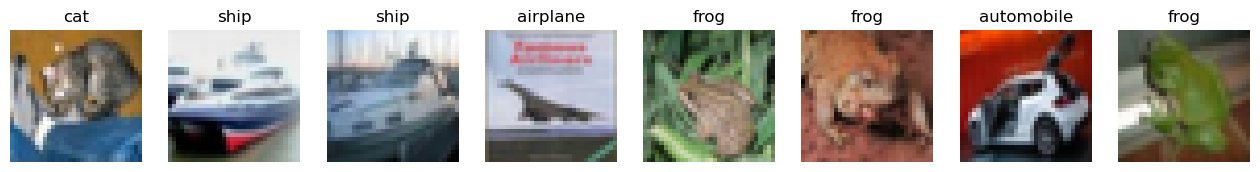

pred: cat  |  true: cat
pred: ship  |  true: ship
pred: ship  |  true: ship
pred: airplane  |  true: airplane
pred: frog  |  true: frog
pred: frog  |  true: frog
pred: automobile  |  true: automobile
pred: frog  |  true: frog


In [8]:
# %%
# Quick inference example: show some predictions from the validation set

def predict_and_show(model, loader, device, classes, n_images=8):
    model.eval()
    with torch.no_grad():
        images, targets = next(iter(loader))
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        imgs = images.cpu()

        targets = targets.squeeze().cpu().numpy()
        imshow_batch(imgs, preds, classes, max_images=n_images)
        # print pairs
        for i in range(min(n_images, len(preds))):
            print(f"pred: {classes[preds[i]]}  |  true: {classes[targets[i]]}")

print("Running a quick inference check (this uses the current model weights)...")
predict_and_show(model, val_loader, device, classes, n_images=8)
